## In-class hands-on activity: Regression Parts 1-2

### Real estate price prediction
主題: 建構迴歸模型、計算預測準確度、與處理類別型特徵。

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。授課教師: 盧信銘。任務設計: 盧信銘。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)
random.seed(1001)

### 資料說明

* 包含新北市, 台北市, 高雄市, 桃園市, 台中市房價資料
* 單價: 新台幣/坪，經過線性轉換，只有相對大小有意義。
* 建物面積、車位面積、陽台面積、附屬建物面積經過線性轉換，只有相對大小有意義。
* 橫坐標、縱坐標經過平移處理。

注意: 原資料提供者為避免法律爭議而進行資料轉換。這件事在一般統計學習與機器學習專案中需審慎為之。務必了解資料轉換對專案目標的影響。

In [2]:
# training data
dftrain = pd.read_csv('./housing_5cities_train.csv')
# test data
dftesta = pd.read_csv('./housing_5cities_testa.csv')
print(f"Training df shape = {dftrain.shape}; test df shape = {dftesta.shape}")

Training df shape = (8140, 21); test df shape = (1031, 21)


In [3]:
dftrain

,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價
0,台北市,大安區,敦化南路二段,-0.256716,NaN,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.183700,-0.438452,4.627714
1,高雄市,鳳山區,北忠街,0.181921,NaN,10,15,集合住宅,其他,住宅大樓(11層含以上有電梯),6.166667,0.423366,0.161624,1.0,184815,2504666,NaN,-0.098871,-0.360620,1.525881,1.489072
2,新北市,新莊區,福前街,0.085594,NaN,9,14,集合住宅,鋼筋混凝土造,住宅大樓(11層含以上有電梯),8.833333,0.164249,0.524653,1.0,296653,2772355,NaN,-0.071147,0.315088,0.231984,2.051217
3,台北市,萬華區,國興路,0.260510,NaN,2,12,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),39.333333,-0.411438,-0.819326,0.0,301365,2768583,NaN,-0.371295,-0.618277,-0.438452,2.238599
4,新北市,樹林區,信義街,0.856422,NaN,2,4,住家用,鋼筋混凝土造,公寓(5樓含以下無電梯),46.000000,-0.868770,-0.819326,0.0,292687,2763850,NaN,-0.245408,-1.642077,-0.438452,1.348536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8135,台北市,內湖區,陽光街,0.544299,NaN,5,5,住家用,鋼筋混凝土造,公寓(5樓含以下無電梯),39.166667,-0.378115,-0.819326,0.0,309040,2774177,NaN,0.241730,0.233184,-0.438452,2.660207
8136,新北市,新莊區,幸福東路,1.390665,NaN,3,25,集合住宅,鋼骨造,住宅大樓(11層含以上有電梯),1.166667,2.090101,3.220335,2.0,296674,2771379,NaN,1.548971,0.516435,1.143690,2.613362
8137,桃園市,八德區,介壽路二段,0.706189,其他,4,5,住家用,鋼筋混凝土造,公寓(5樓含以下無電梯),28.333333,-0.271825,0.484488,1.0,280165,2758675,NaN,0.146962,-0.181455,-0.171559,0.903505
8138,新北市,土城區,學士路,-1.147111,NaN,12,16,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),25.083333,-1.199130,-0.819326,0.0,295794,2763966,NaN,-1.333408,-0.708713,-0.438452,2.285444


In [4]:
# Summary statistics
dftrain.describe()

,土地面積,移轉層次,總樓層數,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,主建物面積,陽台面積,附屬建物面積,單價
count,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8.140000e+03,8140.000000,8140.000000,8140.000000,8140.000000
mean,-0.000685,7.431818,12.571376,22.164281,0.018220,0.001344,0.617199,273558.099017,2.725461e+06,0.026784,0.026401,0.032724,2.087195
std,1.087028,5.097901,6.906708,14.623925,1.090130,1.034322,0.679794,44740.087322,8.998772e+04,1.089884,1.082033,1.243377,1.008621
min,-1.613242,2.000000,2.000000,0.000000,-1.788606,-0.819326,0.000000,175366.000000,2.495675e+06,-2.070340,-1.642077,-0.438452,0.177415
25%,-0.658185,4.000000,7.000000,8.833333,-0.635508,-0.819326,0.000000,272150.000000,2.758728e+06,-0.622573,-0.637473,-0.438452,1.395381
50%,-0.171048,6.000000,12.000000,22.500000,-0.216670,-0.538172,1.000000,295689.000000,2.767386e+06,-0.149791,-0.070544,-0.438452,1.816990
75%,0.384950,10.000000,15.000000,33.500000,0.332158,0.674885,1.000000,302298.750000,2.772287e+06,0.404393,0.474203,0.144443,2.519671
max,19.475175,46.000000,68.000000,60.083333,9.181627,9.221895,3.000000,326906.000000,2.790801e+06,10.800366,13.842902,33.713188,11.326608


可以很明確地看到土地面積、建物面積、車位面積、主建物面積、陽台面積、單價有被標準化的痕跡。

---

Exploratory Data Analysis (EDA)不是這個練習的重點，因此選擇性的畫個圖看一下。

<Axes: xlabel='縣市', ylabel='單價'>

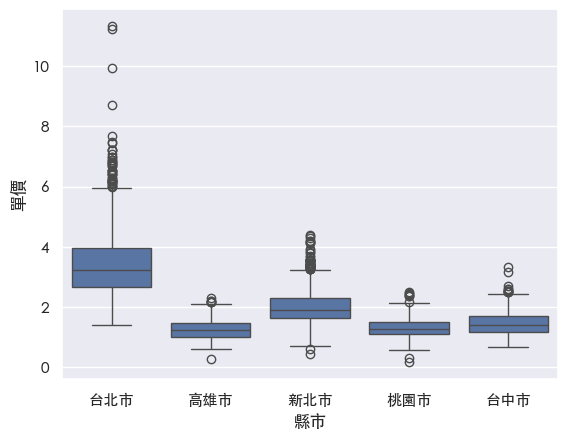

In [5]:
# 確保中文能正常顯示
sns.set(font="Heiti TC")
sns.boxplot(dftrain, x = "縣市", y = "單價")

### Fit a linear model;
Recall that the closed form solution for linear regression coefficient is:

$\hat{\beta} = (X^T X)^{-1} X^T y$

You may need to leverage the following methods:
* df.to_numpy
* numpy.linalg.inv or numpy.linalg.solve
* numpy.matmul or @
* numpy.ones
* numpy.hstack


In [6]:
# TODO
def fit_linear_reg(X_train, y_train):
    # implement the closed form solution for linear regression
    # return the fitted coefficients
    # remember to add a column of ones first
    
    # Add a column of ones for the intercept term
    X_with_intercept = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    
    # Closed form solution: β̂ = (X^T X)^(-1) X^T y
    XTX = np.matmul(X_with_intercept.T, X_with_intercept)
    XTX_inv = np.linalg.inv(XTX)
    XTy = np.matmul(X_with_intercept.T, y_train)
    beta = np.matmul(XTX_inv, XTy)
    
    return beta

In [7]:
numfeatures = ['建物面積', '總樓層數', '屋齡']
label = '單價'
X_train = dftrain[numfeatures].to_numpy()
y_train = dftrain[label].to_numpy()
X_test = dftesta[numfeatures].to_numpy()
y_test = dftesta[label].to_numpy()

beta_head = fit_linear_reg(X_train, y_train)

for abeta, aname in zip(beta_head, ['Const.'] + numfeatures):
    print(f"{aname}\t{abeta:.4f}")

Const.	1.8937
建物面積	0.0454
總樓層數	0.0042
屋齡	0.0063


### Sanity Check
The cell output should be like:
<pre>
Const.	1.8937
建物面積	0.0454
總樓層數	0.0042
屋齡	0.0063
</pre>

### Compute $R^2$

In [8]:
# TODO
def get_r2(X, y, beta):
    # Compute R2 given X, y, and beta
    # return R2 as a scalar
    
    # Add intercept column to X (assuming beta includes intercept as first element)
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Calculate predictions: y_pred = X * beta
    y_pred = np.matmul(X_with_intercept, beta)
    
    # Calculate R² = 1 - (SS_res / SS_tot)
    # SS_res = sum of squared residuals
    ss_res = np.sum((y - y_pred) ** 2)
    
    # SS_tot = total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    
    # R² = 1 - (SS_res / SS_tot)
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

In [9]:
r2 = get_r2(X_train, y_train, beta_head)
print(f"R2 = {r2:.4f}")

R2 = 0.0071


## Sanity Check
The above cell should have an output like this:
<pre>
R2 = 0.0071
</pre>

### Extend get_r2 to also compute RMSE, MAE, MAPE

In [10]:
# TODO
def get_performance(X, y, beta):
    # Compute R2, RMSE, MAE, MAPE given X, y, and beta
    # return R2, RMSE, MAE, MAPE as a list
    
    # Add intercept column to X (assuming beta includes intercept as first element)
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Calculate predictions: y_pred = X * beta
    y_pred = np.matmul(X_with_intercept, beta)
    
    # Calculate R² = 1 - (SS_res / SS_tot)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Calculate RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))
    
    # Calculate MAE (Mean Absolute Error)
    mae = np.mean(np.abs(y - y_pred))
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Avoid division by zero by adding small epsilon
    epsilon = 1e-8
    mape = np.mean(np.abs((y - y_pred) / (y + epsilon)))
    
    return r2, rmse, mae, mape

In [11]:
# performance on training data
r2, RMSE, MAE, MAPE = get_performance(X_train, y_train, beta_head)
print(f"R2 = {r2:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAE = {MAE:.4f}")
print(f"MAPE = {MAPE:.4f}")

R2 = 0.0071
RMSE = 1.0050
MAE = 0.7498
MAPE = 0.4166


### Sanity Check
The above cell should have an output like this:
<pre>
R2 = 0.0071
RMSE = 1.0050
MAE = 0.7498
MAPE = 0.4166
</pre>

In [12]:
# performance on test data
r2, RMSE, MAE, MAPE = get_performance(X_test, y_test, beta_head)
print(f"R2 = {r2:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAE = {MAE:.4f}")
print(f"MAPE = {MAPE:.4f}")

R2 = 0.0173
RMSE = 1.0382
MAE = 0.7238
MAPE = 0.3965


### Sanity Check
The above cell should have an output like this:
<pre>
R2 = 0.0173
RMSE = 1.0382
MAE = 0.7238
MAPE = 0.3965
</pre>

### Deal with categorical features

In [13]:
# TODO
def gen_features(dftrain, dftest, numfeatures, catfeatures, enc):
    # Generate additional categorical features according to catfeatures
    # use enc to help you generate feature one-hot encoding. 
    # np.hstack will be useful here. 
    # Arrange numpy array such that numerical features go first, followed by categorical features
    # return the feature arrary for training and test data
    
    # Extract numerical features
    X_train_num = dftrain[numfeatures].to_numpy()
    X_test_num = dftest[numfeatures].to_numpy()
    
    # Extract categorical features
    X_train_cat = dftrain[catfeatures].to_numpy()
    X_test_cat = dftest[catfeatures].to_numpy()
    
    # Fit the encoder on training data and transform both training and test data
    X_train_cat_encoded = enc.fit_transform(X_train_cat).toarray()
    X_test_cat_encoded = enc.transform(X_test_cat).toarray()
    
    # Combine numerical features first, then categorical features
    X_train_combined = np.hstack([X_train_num, X_train_cat_encoded])
    X_test_combined = np.hstack([X_test_num, X_test_cat_encoded])
    
    return X_train_combined, X_test_combined


In [14]:
numfeatures = ['建物面積', '總樓層數', '屋齡']
catfeatures = ['縣市']
label = '單價'

enc = OneHotEncoder(drop="first")
X_train2, X_test2 = gen_features(dftrain, dftesta, numfeatures, catfeatures, enc)
y_train2 = dftrain[label].to_numpy()
y_test2 = dftesta[label].to_numpy()

beta_head2 = fit_linear_reg(X_train2, y_train2)

featname = ['Const.'] + numfeatures + list(enc.categories_[0][1:])
for abeta, aname in zip(beta_head2, featname):
    print(f"{aname}\t{abeta:.4f}")

Const.	1.3455
建物面積	0.0095
總樓層數	0.0211
屋齡	-0.0123
台北市	2.2398
新北市	0.6374
桃園市	-0.1296
高雄市	-0.2285


### Sanity Check
The above cell should have an output like this:
<pre>
Const.	1.3455
建物面積	0.0095
總樓層數	0.0211
屋齡	-0.0123
台北市	2.2398
新北市	0.6374
桃園市	-0.1296
高雄市	-0.2285
</pre>

In [15]:
# Check training performance
r2, RMSE, MAE, MAPE = get_performance(X_train2, y_train2, beta_head2)
print(f"R2 = {r2:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAE = {MAE:.4f}")
print(f"MAPE = {MAPE:.4f}")

R2 = 0.6715
RMSE = 0.5781
MAE = 0.3983
MAPE = 0.1964


### Sanity Check
The above cell should have an output like this:
<pre>
R2 = 0.6715
RMSE = 0.5781
MAE = 0.3983
MAPE = 0.1964
</pre>

In [16]:
# Check test performance
r2, RMSE, MAE, MAPE = get_performance(X_test2, y_test2, beta_head2)
print(f"R2 = {r2:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAE = {MAE:.4f}")
print(f"MAPE = {MAPE:.4f}")

R2 = 0.5937
RMSE = 0.6676
MAE = 0.4050
MAPE = 0.1933


### Sanity Check
The above cell should have an output like this:
<pre>
R2 = 0.5937
RMSE = 0.6676
MAE = 0.4050
MAPE = 0.1933
</pre>


### Before closing out today's activity

Let's take a look at the locations in our training data.
How can we leverage the locations in our models?

After all, the most important factors in real estate is: <h3>Location, Location, Location.</h3>

<Axes: xlabel='橫坐標', ylabel='縱坐標'>

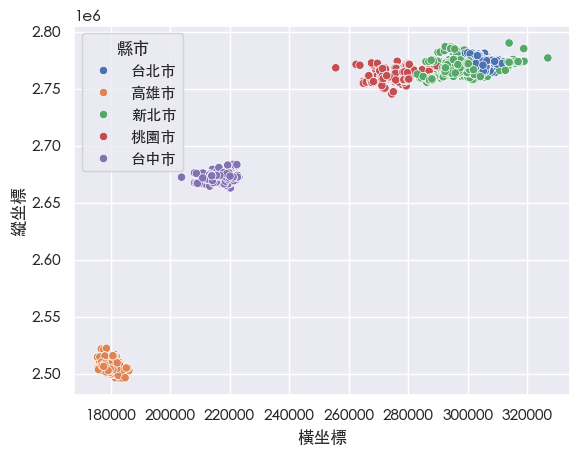

In [17]:
sns.scatterplot(dftrain, x="橫坐標", y="縱坐標", hue = "縣市")

In [18]:
dftrain_ks = dftrain[dftrain.縣市 == "高雄市"]

<Axes: xlabel='橫坐標', ylabel='縱坐標'>

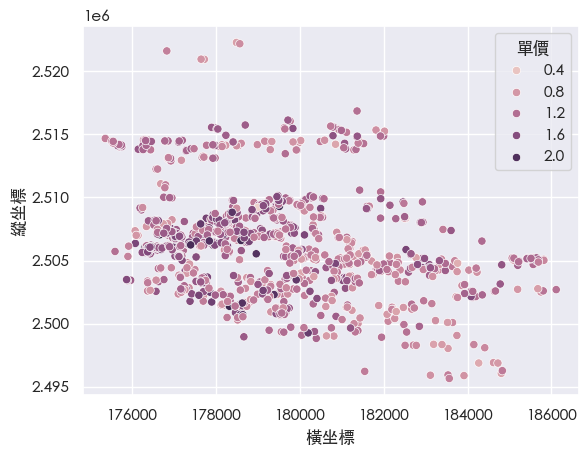

In [19]:
sns.scatterplot(dftrain_ks, x="橫坐標", y="縱坐標", hue = "單價")

---- 
End of File

---